In [1]:
import pandas as pd
import numpy as np

import warnings
import re
import string
import nltk
from nltk.corpus import stopwords # удаление служебных слов
import spacy # для работы с текстом
from datetime import datetime # для работы с временными переменными
from collections import Counter


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD # уменьшение размерности
from sklearn.feature_extraction.text import TfidfVectorizer # векторизация слов
from sklearn.feature_selection import RFE # отбор признаков
from sklearn.metrics import r2_score, mean_squared_error, classification_report, accuracy_score # метрика задачи
import category_encoders as ce

from gensim.models.fasttext import FastText # векторизация слов
from gensim.matutils import unitvec # унифицирование ембедингов предложений
from pytorch_tabnet.metrics import Metric # класс для создания кастомной метрики
from pytorch_tabnet.tab_model import TabNetRegressor

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
# снять ограничение на кол-во показываемых колонок
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
df_issues_train = pd.read_csv("train_issues.csv")
df_comment_train = pd.read_csv("train_comments.csv")

df_issues_test = pd.read_csv("test_issues.csv")
df_comment_test = pd.read_csv("test_comments.csv")

df_emp = pd.read_csv("employees.csv")

sample_solution = pd.read_csv('sample_solution.csv', index_col='id')

# df_issues_train

In [4]:
df_issues_train.head(5)

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs
0,819952,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800
1,819949,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",5,93,93,7200
2,819947,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",5,93,93,14400
3,819943,2019-10-01 06:02:49.000,SM-10682,"UI тесты раздела ""Новости""",5,93,93,900
4,819941,2019-10-01 06:03:26.000,SM-10683,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900


In [5]:
df_issues_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9589 entries, 0 to 9588
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                9589 non-null   int64 
 1   created           9589 non-null   object
 2   key               9589 non-null   object
 3   summary           9589 non-null   object
 4   project_id        9589 non-null   int64 
 5   assignee_id       9589 non-null   int64 
 6   creator_id        9589 non-null   int64 
 7   overall_worklogs  9589 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 599.4+ KB


In [6]:
# удалим выбросы
df_issues_train = df_issues_train.drop(df_issues_train[df_issues_train['overall_worklogs'] > 170000].index)

In [7]:
# удалим выбросы
df_issues_train = df_issues_train.drop(df_issues_train[df_issues_train['overall_worklogs'] > 170000].index)

# удалим лишнюю колонку
df_issues_train.drop('key',1,inplace=True)
df_issues_test.drop('key',1,inplace=True)

# переменная содержащая инфу о том является ли создатель и исполнитель одним и тем же человеком
def is_equal(vals):
    if vals[0] == vals[1]:
        return 1
    return 0
df_issues_train['assignee_is_creator'] = list(map(is_equal, df_issues_train[['assignee_id', 'creator_id']].values))
df_issues_test['assignee_is_creator'] = list(map(is_equal, df_issues_test[['assignee_id', 'creator_id']].values))

# time featuring
df_issues_train['created'] = pd.to_datetime(df_issues_train['created'].map(lambda x: x[:-4]), format = "%Y-%m-%d %H:%M:%S")
df_issues_test['created'] = pd.to_datetime(df_issues_test['created'].map(lambda x: x[:-4]), format = "%Y-%m-%d %H:%M:%S")

df_issues_train['created_year'] = pd.DatetimeIndex(df_issues_train['created']).year
df_issues_train['created_month'] = pd.DatetimeIndex(df_issues_train['created']).month
df_issues_train['created_day'] = pd.DatetimeIndex(df_issues_train['created']).day
df_issues_train['created_day_of_week'] = pd.DatetimeIndex(df_issues_train['created']).day_of_week
df_issues_train['created_hour'] = pd.DatetimeIndex(df_issues_train['created']).hour
df_issues_train['created_minute'] = pd.DatetimeIndex(df_issues_train['created']).minute

df_issues_test['created_year'] = pd.DatetimeIndex(df_issues_test['created']).year
df_issues_test['created_month'] = pd.DatetimeIndex(df_issues_test['created']).month
df_issues_test['created_day'] = pd.DatetimeIndex(df_issues_test['created']).day
df_issues_test['created_day_of_week'] = pd.DatetimeIndex(df_issues_test['created']).day_of_week
df_issues_test['created_hour'] = pd.DatetimeIndex(df_issues_test['created']).hour
df_issues_test['created_minute'] = pd.DatetimeIndex(df_issues_test['created']).minute

def clean_text(text):
    # приводим текст к нижнему регистру
    text = text.lower()
    # создаем регулярное выражение для удаления лишних символов
    regular = r'[\*+\#+\№\"\-+\+\=+\?+\&\^\.+\;\,+\>+\(\)\/+\:\\+]'
    # регулярное выражение для замены ссылки на "URL"
    regular_url = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)'
    # удаляем лишние символы
    text = re.sub(regular, '', text)
    # заменяем ссылки на "URL"
    text = re.sub(regular_url, r'URL', text)
    # заменяем числа и цифры на ' NUM '
    text = re.sub(r'(\d+\s\d+)|(\d+)',' NUM ', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # возвращаем очищенные данные
    return text

# очистим текст
df_issues_train['summary'] = df_issues_train['summary'].map(lambda x: clean_text(x))
df_issues_test['summary'] = df_issues_test['summary'].map(lambda x: clean_text(x))

# является ли текст русским 
def has_cyrillic(text):
    return int(bool(re.search('[а-яА-Я]', text)))

df_issues_train['summary_is_ru'] = df_issues_train['summary'].map(lambda x: has_cyrillic(x))
df_issues_test['summary_is_ru'] = df_issues_test['summary'].map(lambda x: has_cyrillic(x))

# загрузим предобработчик для английского и русского
nlp_en = spacy.load("en_core_web_sm")
nlp_ru = spacy.load("ru_core_news_sm")

def lemmatize(x):
    if x[1]:
        return [i.lemma_ for i in nlp_ru(x[0])]
    return [i.lemma_ for i in nlp_en(x[0])]

# лематизация
df_issues_train['summary'] = list(map(lemmatize, df_issues_train[['summary', 'summary_is_ru']].values))
df_issues_test['summary'] = list(map(lemmatize, df_issues_test[['summary', 'summary_is_ru']].values))

# стоп-слова удалить после токенизации и лемматизации
stop_words = stopwords.words('russian') + stopwords.words('english')

df_issues_train['summary'] = df_issues_train['summary'].map(lambda x: [word for word in x if word not in stop_words])
df_issues_test['summary'] = df_issues_test['summary'].map(lambda x: [word for word in x if word not in stop_words])

# количество слов
df_issues_train['summary_len'] = df_issues_train['summary'].map(lambda x: len(x))
df_issues_test['summary_len'] = df_issues_test['summary'].map(lambda x: len(x))

In [8]:
# после предобработки текста можно его закодировать
vector_size = 20
ft_model = FastText(df_issues_train['summary'], vector_size = vector_size, min_count = 20, \
                    sample = 1e-2, window = 30, epochs = 20)

def fast_encode(x):
    if len(x) == 0:
        return np.zeros(vector_size)
    vec = sum([ft_model.wv[i] for i in x])
    return vec/np.linalg.norm(vec)

df_issues_train['summary'] = df_issues_train['summary'].map(lambda x: fast_encode(x))
df_issues_test['summary'] = df_issues_test['summary'].map(lambda x: fast_encode(x))

df_issues_train[[f'summary_{i}' for i in range(vector_size)]] = np.concatenate(df_issues_train['summary'].values).reshape( -1, vector_size)
df_issues_test[[f'summary_{i}' for i in range(vector_size)]] = np.concatenate(df_issues_test['summary'].values).reshape( -1, vector_size)

df_issues_train = df_issues_train.drop('summary',1)
df_issues_test = df_issues_test.drop('summary',1)

In [9]:
# сколько было кейсов до выполнения данного кейса
def count_issues_before(x, test = False):
    if test:
        data = pd.concat([df_issues_train, df_issues_test], 0)
    else:
        data = df_issues_train
    assignee = data[data['id'] == x]['assignee_id'].any()
    created_time = data[data['id'] == x].values[0][1]
    return len(data[(data['assignee_id'] == assignee) & (data['created'] < created_time)])

df_issues_train['issues_before'] = df_issues_train['id'].map(lambda x: count_issues_before(x))
df_issues_test['issues_before'] = df_issues_test['id'].map(lambda x: count_issues_before(x, test = True))

<AxesSubplot:xlabel='issues_before', ylabel='overall_worklogs'>

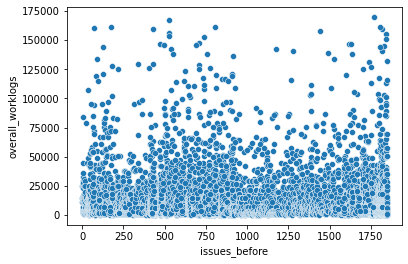

In [10]:
sns.scatterplot(data = df_issues_train, x = 'issues_before', y = 'overall_worklogs')

# df_comment_train

In [11]:
df_comment_train.head(5)

,comment_id,text,issue_id,author_id
0,11779,[https://www.youtube.com/watch?v=tuhOdtsvoNY|h...,669666,1
1,10601,OK [~accountid:557058:3f7ab89a-8969-4547-90df-...,669670,1
2,76101,I encountered a problem with access to `/users...,670930,2
3,76102,I have learned that `users/:id/emails` endpoin...,670930,2
4,76213,We have decided with Andrew to set member's em...,670930,2


In [12]:
df_comment_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13918 entries, 0 to 13917
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  13918 non-null  int64 
 1   text        13918 non-null  object
 2   issue_id    13918 non-null  int64 
 3   author_id   13918 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 435.1+ KB


In [13]:
# посчитаем упоминания людей
df_comment_train['number_of_entity'] = df_comment_train['text'].map( lambda x: len(re.findall(r'\[~', x)) )
df_comment_test['number_of_entity'] = df_comment_test['text'].map( lambda x: len(re.findall(r'\[~', x)) )

In [14]:
# очистим текст
df_comment_train['text'] = df_comment_train['text'].map(lambda x: clean_text(x))
df_comment_test['text'] = df_comment_test['text'].map(lambda x: clean_text(x))

df_comment_train['number_of_url'] = df_comment_train['text'].map(lambda x: len(re.findall('URL', x)))
df_comment_test['number_of_url'] = df_comment_test['text'].map(lambda x: len(re.findall('URL', x)))

# является ли текст русским 
df_comment_train['text_is_ru'] = df_comment_train['text'].map(lambda x: has_cyrillic(x))
df_comment_test['text_is_ru'] = df_comment_test['text'].map(lambda x: has_cyrillic(x))

# лематизация
df_comment_train['text'] = list(map(lemmatize, df_comment_train[['text', 'text_is_ru']].values))
df_comment_test['text'] = list(map(lemmatize, df_comment_test[['text', 'text_is_ru']].values))

# стоп-слова удалить после токенизации и лемматизации
df_comment_train['text'] = df_comment_train['text'].map(lambda x: [word for word in x if word not in stop_words])
df_comment_test['text'] = df_comment_test['text'].map(lambda x: [word for word in x if word not in stop_words])

# удалим самые частовстречающиеся слова
words = Counter(df_comment_train['text'].sum())
most_common_words = words.most_common(36)

df_comment_train['text'] = df_comment_train['text'].map(lambda x: [word for word in x if word not in most_common_words])
df_comment_test['text'] = df_comment_test['text'].map(lambda x: [word for word in x if word not in most_common_words])

# количество слов
df_comment_train['text_len'] = df_comment_train['text'].map(lambda x: len(x))
df_comment_test['text_len'] = df_comment_test['text'].map(lambda x: len(x))

In [15]:
df_comment_train

,comment_id,text,issue_id,author_id,number_of_entity,number_of_url,text_is_ru,text_len
0,11779,"[[, url, thank, gay, help, I, finish, test, wo...",669666,1,0,1,0,10
1,10601,"[ok, [, ~accountid, NUM, f, NUM, ab, NUM, NUM,...",669670,1,1,0,0,22
2,76101,"[I, encounter, problem, access, `, usersidemai...",670930,2,0,0,0,25
3,76102,"[I, learn, `, usersidemails, `, endpoint, avai...",670930,2,1,0,0,32
4,76213,"[decide, andrew, set, member, 's, email, manua...",670930,2,0,0,0,12
...,...,...,...,...,...,...,...,...
13913,65207,"[[, ~alexandermedvedev, ], fix, console, error...",689203,58,1,3,0,30
13914,64891,"[need, information, customer, need, migrate, o...",689220,58,0,0,0,15
13915,65166,"[[, ~marat, ], sort, already, I, remember, cor...",689220,58,1,0,0,8
13916,65229,"[yes, I, get, sql, dump, database, file, stora...",689220,1,1,0,0,15


# df_emp

In [16]:
df_emp.head(5)

,id,active,full_name,position,hiring_type,payment_type,salary_calculation_type,english_level,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,1,1,David Courtney,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,2,0,Dan Guerra,Web-разработчик,staff,fixed,NaN,NaN,0,0,0,0,0
2,4,0,Grady Smith,Web-разработчик,staff,fixed,NaN,NaN,0,0,0,0,0
3,6,0,James Powell,Разработчик мобильных приложений,staff,fixed,NaN,NaN,0,0,0,0,0
4,8,1,John Brown,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1


In [17]:
df_emp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          343 non-null    int64 
 1   active                      343 non-null    int64 
 2   full_name                   343 non-null    object
 3   position                    193 non-null    object
 4   hiring_type                 260 non-null    object
 5   payment_type                221 non-null    object
 6   salary_calculation_type     33 non-null     object
 7   english_level               16 non-null     object
 8   passport                    343 non-null    int64 
 9   is_nda_signed               343 non-null    int64 
 10  is_labor_contract_signed    343 non-null    int64 
 11  is_added_to_internal_chats  343 non-null    int64 
 12  is_added_one_to_one         343 non-null    int64 
dtypes: int64(7), object(6)
memory usage: 35.0+ KB


In [18]:
# # position one hot encoding
# df_emp = df_emp.fillna({'position': 'none'})
# position_list = ['web', 'разработчик', 'менеджер', 'дизайнер', 'директор', 'инженер', 'none']
# def find_position(x):
#     if re.search(position, x.lower()):
#         return 1
#     return 0
# for position in position_list:
#     df_emp[f'position_{position}'] = df_emp['position'].map(lambda x: find_position(x))
# df_emp = df_emp.drop('position', 1)

# я не знаю как можно обработать имя, поэтому удалю колонку
df_emp.drop(['full_name'],1,inplace=True)

# отсутствие информации тожеможет быть информацией
df_emp = df_emp.fillna({'hiring_type':'none', 'payment_type':'none', 'salary_calculation_type':'none'})

# есть пропуск или нет
df_emp['english_level'] = df_emp['english_level'].notna().astype(int)

# Аггрегации данных из разных таблиц

In [19]:
# В скольких проектах участвует работник
def count_project(x, test = False):
    if test:
        data = df_issues_test
    else:
        data = pd.concat([df_issues_train, df_issues_test], 0)
        
    return data[(data['assignee_id'] == x) | (data['creator_id'] == x)]['project_id'].nunique()
df_emp['number_of_projects'] = df_emp['id'].map(lambda x: count_project(x, test = True))

In [20]:
# sns.boxplot(data = pd.merge(df_issues_train, df_emp, left_on='assignee_id', right_on='id', how='left'), x = 'number_of_projects', y = 'overall_worklogs', showfliers = False)

In [21]:
# Сколько в среднем сообщений на кейс пишет работник
def count_messages(x, test = False):
    if test:
        data = pd.concat([df_comment_train, df_comment_test], 0)
    else:
        data = df_comment_train
    
    comments_of_worker = data[data['author_id'] == x]
    if len(comments_of_worker) != 0:
        return len(comments_of_worker) / comments_of_worker['issue_id'].nunique()
    return 0.0
df_emp['messages_written'] = df_emp['id'].map(lambda x: count_messages(x, test = True))

In [22]:
# sns.lineplot(data = pd.merge(df_issues_train, df_emp, left_on='assignee_id', right_on='id', how='left'), x = 'messages_written', y = 'overall_worklogs')

In [23]:
# сколько раз появлялся в качестве creator
def appeared_in_creator_id_times(x, test = False):
    if test:
        data = pd.concat([df_issues_train, df_issues_test], 0)
    else:
        data = df_issues_train
        
    return len(data[(data['creator_id'] == x) & (data['assignee_id'] != x)])
df_emp['appeared_in_creator_id_times'] = df_emp['id'].map(lambda x: appeared_in_creator_id_times(x, test=True))

In [24]:
# sns.lineplot(data = pd.merge(df_issues_train, df_emp, left_on='assignee_id', right_on='id', how='left'), x = 'appeared_in_creator_id_times', y = 'overall_worklogs')

In [25]:
# # сколько раз появлялся в качестве assignee
# def appeared_in_assignee_id_times(x):
#     return len(df_issues_train[(df_issues_train['assignee_id'] == x) & (df_issues_train['creator_id'] != x)])
# df_emp['appeared_in_assignee_id_times'] = df_emp['id'].map(lambda x: appeared_in_assignee_id_times(x))

In [26]:
# sns.lineplot(data = pd.merge(df_issues_train, df_emp, left_on='assignee_id', right_on='id', how='left'), x = 'appeared_in_assignee_id_times', y = 'overall_worklogs')

In [27]:
# # отношение 
# def assignee_creator(x):
#     if len(df_issues_train[(df_issues_train['creator_id'] == x) & (df_issues_train['assignee_id'] != x)]) == 0:
#         return 0
#     return len(df_issues_train[(df_issues_train['assignee_id'] == x) & (df_issues_train['creator_id'] != x)]) / len(df_issues_train[(df_issues_train['creator_id'] == x) & (df_issues_train['assignee_id'] != x)])
# df_emp['assignee_creator'] = df_emp['id'].map(lambda x: assignee_creator(x))

In [28]:
# sns.lineplot(data = pd.merge(df_issues_train, df_emp, left_on='assignee_id', right_on='id', how='left'), x = 'assignee_creator', y = 'overall_worklogs')

In [29]:
# сколько сущностей в тексте
def count_issue_messages(x, test = False):
    if test:
        data = df_comment_test
    else:
        data = df_comment_train
    return data[data['issue_id'] == x]['number_of_entity'].sum()
df_issues_train['number_of_entity'] = df_issues_train['id'].map(lambda x: count_issue_messages(x))
df_issues_test['number_of_entity'] = df_issues_test['id'].map(lambda x: count_issue_messages(x))

<AxesSubplot:xlabel='number_of_entity', ylabel='overall_worklogs'>

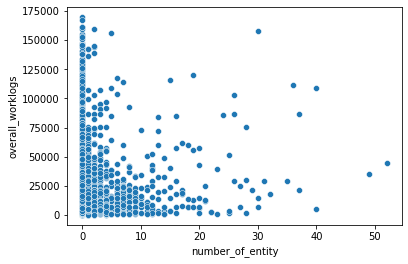

In [30]:
sns.scatterplot(data = df_issues_train, y = 'overall_worklogs', x = 'number_of_entity')

In [32]:
# сколько сообщений в кейсе
def count_issue_messages(x, test = False):
    if test:
        data = df_comment_test
    else:
        data = df_comment_train
    return len(data[data['issue_id'] == x])
df_issues_train['issue_messages'] = df_issues_train['id'].map(lambda x: count_issue_messages(x))
df_issues_test['issue_messages'] = df_issues_test['id'].map(lambda x: count_issue_messages(x))

<AxesSubplot:xlabel='issue_messages', ylabel='overall_worklogs'>

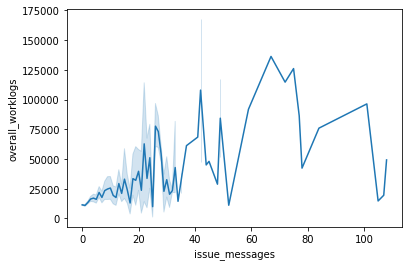

In [33]:
sns.lineplot(data = df_issues_train, x = 'issue_messages', y = 'overall_worklogs')

In [34]:
# среднее количество слов в кейсе
def mean_issue_message_len(x, test = False):
    if test:
        data = df_comment_test
    else:
        data = df_comment_train
    if (data[data['issue_id'] == x]['text_len'] == 0).any():
        return 0
    return data[data['issue_id'] == x]['text_len'].mean()
df_issues_train['mean_issue_message_len'] = df_issues_train['id'].map(lambda x: mean_issue_message_len(x))
df_issues_test['mean_issue_message_len'] = df_issues_test['id'].map(lambda x: mean_issue_message_len(x, test = True))

In [35]:
df_issues_train = df_issues_train.fillna({'mean_issue_message_len': 0})
df_issues_test = df_issues_test.fillna({'mean_issue_message_len': 0})

<AxesSubplot:xlabel='mean_issue_message_len', ylabel='overall_worklogs'>

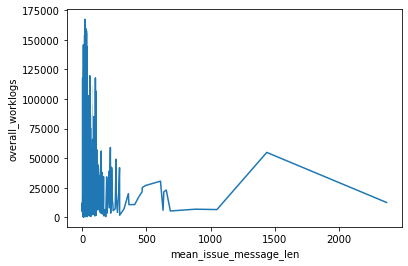

In [36]:
sns.lineplot(data = df_issues_train, x = 'mean_issue_message_len', y = 'overall_worklogs')

In [37]:
# сколько людей писали комментарии к кейсу
def count_workers_under_issue(x, test = False):
    if test:
        data = df_comment_test
    else:
        data = df_comment_train
    return data[data['issue_id'] == x]['author_id'].nunique()
df_issues_train['workers_under_issue'] = df_issues_train['id'].map(lambda x: count_workers_under_issue(x))
df_issues_test['workers_under_issue'] = df_issues_test['id'].map(lambda x: count_workers_under_issue(x, test = True))

In [38]:
# sns.boxplot(data = df_issues_train, x = 'workers_under_issue', y = 'overall_worklogs', showfliers = False)

In [39]:
# количество ссылок на кейс
def sum_of_url(x, test = False):
    if test:
        data = df_comment_test
    else:
        data = df_comment_train
    return data[data['issue_id'] == x]['number_of_url'].sum()
df_issues_train['url_sum'] = df_issues_train['id'].map(lambda x: sum_of_url(x))
df_issues_test['url_sum'] = df_issues_test['id'].map(lambda x: sum_of_url(x, test = True))

In [40]:
# sns.lineplot(data = df_issues_train, x = 'url_sum', y = 'overall_worklogs')

In [41]:
# количество сообщений на русском
def text_is_ru(x, test = False):
    if test:
        data = df_comment_test
    else:
        data = df_comment_train
    return data[data['issue_id'] == x]['text_is_ru'].sum()
df_issues_train['text_is_ru'] = df_issues_train['id'].map(lambda x: text_is_ru(x))
df_issues_test['text_is_ru'] = df_issues_test['id'].map(lambda x: text_is_ru(x, test = True))

In [42]:
# sns.barplot(data = df_issues_train, x = 'text_is_ru', y = 'overall_worklogs')

# Присоединение таблиц df_comment

In [43]:
def join_text(df_comment):
    temp_df_comment_train = pd.DataFrame(columns = ['issue_id', 'text'])
    for i, idx in enumerate(df_comment['issue_id'].unique()):
        text = df_comment[df_comment['issue_id'] == idx]['text'].sum() # тексты относящиеся к одному случаю
        row = [idx, text] # создаём строчку
        temp_df_comment_train.loc[i] = row # вставляем в temp объединённый текст
    return temp_df_comment_train

df_comment_train = join_text(df_comment_train)
df_comment_test = join_text(df_comment_test)

In [44]:
# джойним датасеты комментариев и запросов
df_issues_train = df_issues_train.merge(df_comment_train, left_on='id', right_on='issue_id', how='left').drop('issue_id', 1)
df_issues_test = df_issues_test.merge(df_comment_test, left_on='id', right_on='issue_id', how='left').drop('issue_id', 1)

# если текст отсутствует заполняем пустым списком
df_issues_train['text'] = df_issues_train['text'].apply(lambda d: d if isinstance(d, list) else [])
df_issues_test['text'] = df_issues_test['text'].apply(lambda d: d if isinstance(d, list) else [])

In [45]:
# после предобработки текста можно его закодировать
vector_size = 45
ft_model = FastText(df_issues_train['text'], vector_size = vector_size, min_count = 20, \
                    sample = 1e-2, window = 30, epochs = 30)

def fast_encode(x):
    if len(x) == 0:
        return np.zeros(vector_size)
    vec = sum([ft_model.wv[i] for i in x])
    return vec/np.linalg.norm(vec)

df_issues_train['text'] = df_issues_train['text'].map(lambda x: fast_encode(x))
df_issues_test['text'] = df_issues_test['text'].map(lambda x: fast_encode(x))

df_issues_train[[f'text_{i}' for i in range(vector_size)]] = np.concatenate(df_issues_train['text'].values).reshape( -1, vector_size)
df_issues_test[[f'text_{i}' for i in range(vector_size)]] = np.concatenate(df_issues_test['text'].values).reshape( -1, vector_size)

df_issues_train = df_issues_train.drop('text',1)
df_issues_test = df_issues_test.drop('text',1)

In [46]:
# # после предобработки текста можно его закодировать
# df_issues_train['text'] = df_issues_train['text'].map(lambda x: ' '.join(x))
# df_issues_test['text'] = df_issues_test['text'].map(lambda x: ' '.join(x))

# # векторизуем
# text_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.50, sublinear_tf=True)

# text_vectorizer.fit(df_issues_train['text'])

# # чтобы вектора предложений были более компактными преобразуем при помощи SVD
# text_svd = TruncatedSVD(n_components=20, n_iter=200)

# df_issues_train[[f'text_svd_{i}' for i in range(text_svd.n_components)]] = text_svd.fit_transform( text_vectorizer.transform(df_issues_train['text']) )
# df_issues_test[[f'text_svd_{i}' for i in range(text_svd.n_components)]] = text_svd.fit_transform( text_vectorizer.transform(df_issues_test['text']) )

# df_issues_train = df_issues_train.drop('text',1)
# df_issues_test = df_issues_test.drop('text',1)

# Присоединение таблиц df_emp

In [47]:
for col in ['hiring_type', 'payment_type', 'salary_calculation_type']:
    le = LabelEncoder()
    df_emp[col] = le.fit_transform(df_emp[col].values)

In [48]:
# функция добавляет суффикс к данным о работнике чтобы можно было отличить assignee от creator
def rename_cols(df, sfx):
    temp_df = df.copy()
    cols = df.columns[1:] # не берём id(первая колонка)
    for col in cols:
        temp_df = temp_df.rename(columns={col: col+sfx})
    return temp_df

# джойним датасеты запросов и работников
train = df_issues_train.merge(rename_cols(df_emp, '_assignee'), left_on='assignee_id', right_on='id', how='left', suffixes = ('', '_assignee_del')).drop(['id_assignee_del',],1)
train = train.merge(rename_cols(df_emp, '_creator'), left_on='creator_id', right_on='id', how='left', suffixes = ('', '_creator_del')).drop(['id_creator_del'],1)

test = df_issues_test.merge(rename_cols(df_emp, '_assignee'), left_on='assignee_id', right_on='id', how='left', suffixes = ('', '_assignee_del')).drop(['id_assignee_del',],1)
test = test.merge(rename_cols(df_emp, '_creator'), left_on='creator_id', right_on='id', how='left', suffixes = ('', '_creator_del')).drop(['id_creator_del'],1)

In [50]:
train = train.sort_values('created').reset_index(drop=True)

# Удаление колонок перед обучением

In [52]:
train = train.drop(['id', 'created', 'assignee_id', 'creator_id'], 1)
test = test.drop(['id', 'created', 'assignee_id', 'creator_id'], 1)

In [181]:
X = train.drop('overall_worklogs', 1)
y = train['overall_worklogs']
X_test = test.copy()

In [384]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=228)

In [385]:
# целевое кодирование

categorial_vars = ['position_assignee', 'position_creator', 'project_id']
encoder = ce.CatBoostEncoder()
encoder.fit(X_train[categorial_vars], Y_train)

X_train[categorial_vars] = encoder.transform(X_train[categorial_vars])
X_val[categorial_vars] = encoder.transform(X_val[categorial_vars])
X_test[categorial_vars] = encoder.transform(X_test[categorial_vars])

In [389]:
cols_to_linear_model = ['hiring_type_assignee', 'payment_type_assignee', 'salary_calculation_type_assignee', \
                        'english_level_assignee', 'passport_assignee', 'is_nda_signed_assignee', \
                        'is_labor_contract_signed_assignee', 'is_added_to_internal_chats_assignee', \
                        'is_added_one_to_one_assignee', 'active_assignee', \
                        'hiring_type_creator', 'payment_type_creator', 'salary_calculation_type_creator', \
                        'english_level_creator', 'passport_creator', 'is_nda_signed_creator', \
                        'is_labor_contract_signed_creator', 'is_added_to_internal_chats_creator', \
                        'is_added_one_to_one_creator', 'active_creator']


svd = TruncatedSVD(n_components=13, n_iter=150)

X_train[[f'svd_{i}' for i in range(svd.n_components)]] = svd.fit_transform(X_train[cols_to_linear_model])
X_val[[f'svd_{i}' for i in range(svd.n_components)]] = svd.transform(X_val[cols_to_linear_model])
X_test[[f'svd_{i}' for i in range(svd.n_components)]] = svd.transform(X_test[cols_to_linear_model])

X_train = X_train.drop(cols_to_linear_model,1)
X_val = X_val.drop(cols_to_linear_model,1)
X_test = X_test.drop(cols_to_linear_model,1)

<AxesSubplot:>

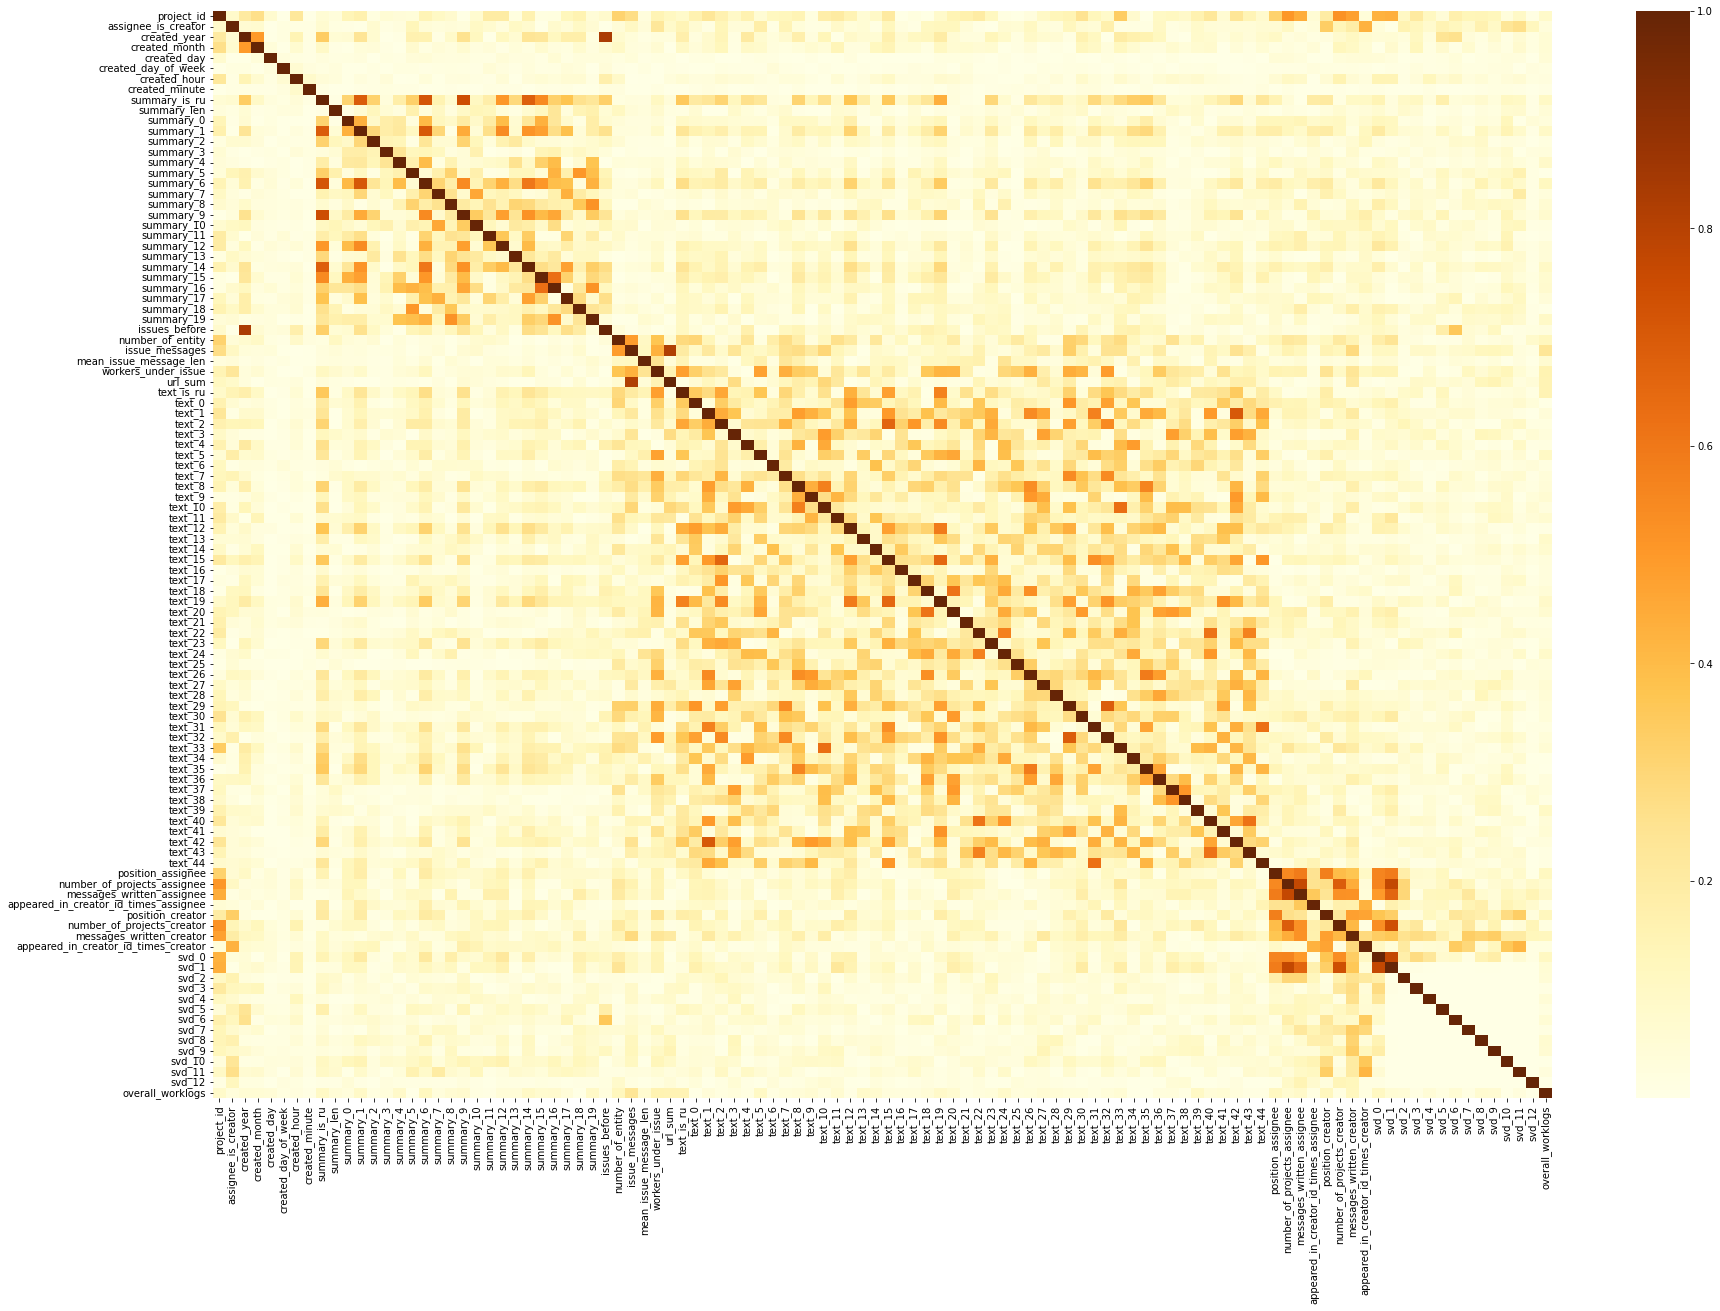

In [390]:
# после всех преобразований взглянем на корреляции
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(pd.concat([X_train, Y_train], 1).corr().abs(),ax=ax, cmap = 'YlOrBr', annot = False)

# XGBRegressor

In [415]:
model = XGBRegressor(max_depth=7, n_estimators=80, reg_alpha = 40, reg_lambda=300, \
                              subsample=0.7, tree_method='gpu_hist', n_jobs=-1,)

In [416]:
model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=80, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=40, reg_lambda=300, ...)

In [417]:
def estimate(model, Y_val, X_val, Y_train, X_train):
    print(f'R2 валидации: {r2_score(Y_val, model.predict(X_val))}\nR2 тренировки: {r2_score(Y_train, model.predict(X_train))}' +
          f'\n\nMSE валидации: {mean_squared_error(Y_val, model.predict(X_val))}\nMSE тренировки: {mean_squared_error(Y_train, model.predict(X_train))}')

In [695]:
estimate(model, Y_val, X_val, Y_train, X_train)

R2 валидации: 0.19319288937509993
R2 тренировки: 0.5715386884038727

MSE валидации: 256511384.78415284
MSE тренировки: 144083806.5481299


<AxesSubplot:>

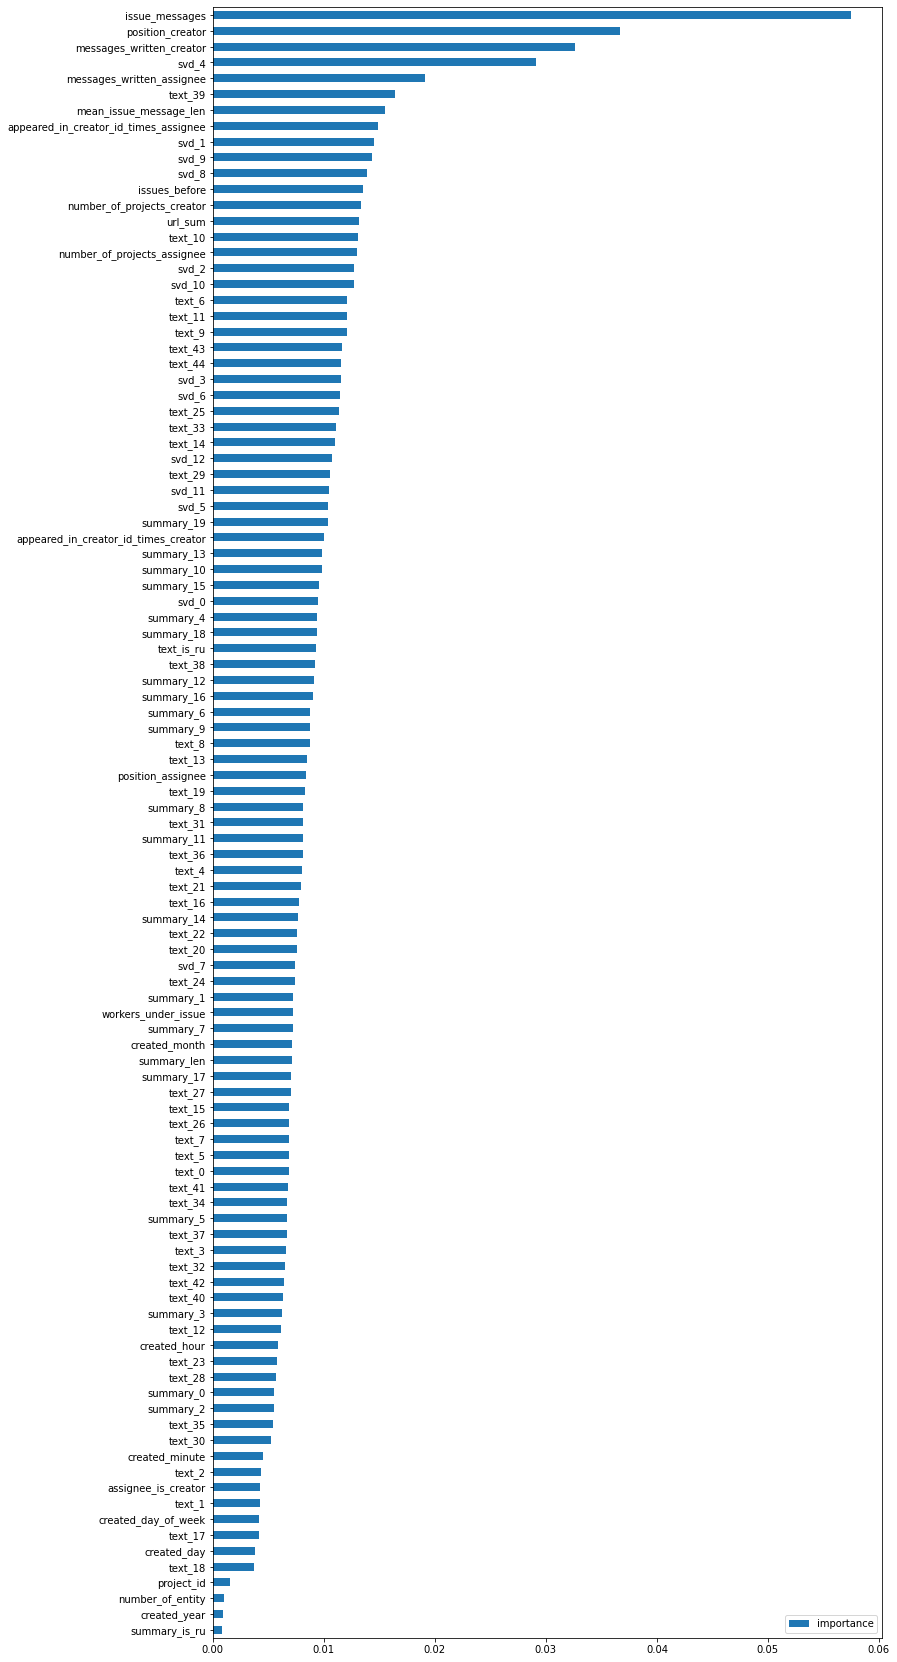

In [419]:
imp = pd.DataFrame(model.feature_importances_, X_val.columns, columns=['importance']).sort_values('importance')
imp.plot(kind='barh', figsize=(12, 30))

# KNeighborsRegressor

In [694]:
class MetaModel():
    def __init__(self, model_list, model_weights):
        self.model_list = model_list
        self.model_weights = model_weights
    def predict(self, X):
        predict = np.zeros( len(X) )
        for model, weight in zip(self.model_list, self.model_weights):
            predict += model.predict(X) * weight
        return predict

In [659]:
class LMWrapper(BaseEstimator, ClassifierMixin):  
    """Обертка для линейных и иных простых моделей 
    для использования масштабирования"""

    def __init__(self, model,scaler, cols_to_drop = None):
        
        self.model = model
        self.scaler = scaler
        self.cols_to_drop = cols_to_drop
        
    def fit(self, X_orig, y=None):
        X = X_orig.copy()
        if self.cols_to_drop != None:
            X = X.drop(self.cols_to_drop, 1)
        
        X_sc = self.scaler.fit_transform(X)
        self.model.fit(X_sc, y) 

        return self

    def predict(self, X_test_orig, y=None):
        X_test_sc = X_test_orig.copy()
        if self.cols_to_drop != None:
            X_test_sc = X_test_sc.drop(self.cols_to_drop, 1)
        X_test_sc = self.scaler.transform(X_test_sc)
        prediction = self.model.predict(X_test_sc)
        
        return prediction

In [660]:
cols_to_drop_1 = [f'text_{i}' for i in range(43)] + [f'summary_{i}' for i in range(5)]

In [661]:
knn2 = LMWrapper(KNeighborsRegressor(n_neighbors=19),StandardScaler(), cols_to_drop_1)

In [662]:
knn2.fit(X_train, Y_train)
estimate(knn2, Y_val, X_val, Y_train, X_train)

R2 валидации: 0.1606264159835441
R2 тренировки: 0.216584288476648

MSE валидации: 266865372.84052238
MSE тренировки: 263448565.29846007


In [663]:
cols_to_drop = imp[:91].index

In [664]:
knn = LMWrapper(KNeighborsRegressor(n_neighbors=11),StandardScaler(), cols_to_drop)

In [665]:
knn.fit(X_train, Y_train)
estimate(knn, Y_val, X_val, Y_train, X_train)

R2 валидации: 0.1792085605542293
R2 тренировки: 0.2844604185651811

MSE валидации: 260957477.91332728
MSE тренировки: 240623047.7261045


In [692]:
knn_models = MetaModel([knn2, knn], [0.45, 0.55])

In [693]:
estimate(knn_models, Y_val, X_val, Y_train, X_train)

R2 валидации: 0.20294044883961593
R2 тренировки: 0.28310769489570786

MSE валидации: 253412304.54107928
MSE тренировки: 241077944.28322744


# Meta model

In [709]:
sas = MetaModel([knn_models, model], [0.55, 0.45])

In [710]:
estimate(sas, Y_val, X_val, Y_train, X_train)

R2 валидации: 0.2277599048032254
R2 тренировки: 0.4451725184279617

MSE валидации: 245521356.46318778
MSE тренировки: 186578468.9511608


In [711]:
predict = sas.predict(X_test)

In [712]:
# sample_solution

predict = sas.predict(X_test)

sample_solution = pd.read_csv('sample_solution.csv', index_col='id')
sample_solution['overall_worklogs'] = predict
sample_solution.to_csv('sample_solution_sas_MetaModel.csv')